# Analyzing WeRateDogs Twitter Data
by Micah Costello

In this project, I will go through the entire data analysis process, from gathering and cleaning to exploration and analysis, in order to produce insights on data from the Twitter page WeRateDogs. This page is famous for posting dog ratings: a picture of a follower's dog and a rating of the dog, usually an absurdly high rating like 13/10.

I'll be using data from 3 sources: 

* the Twitter archive
* a file of image predictions from a neural network whose goal is to predict the dog breed shown in the Tweet image
* Data gathered from the Twitter API

With the data gathered from these sources, I will try to answer the following question:

###   <p style="text-align: center;">How has the WeRateDogs Twitter page changed over time?</p>



The process is divided into 6 steps:

1. Data Gathering
2. Assessment
3. Data Cleaning
4. Augmenting the Data
5. Storing Data
6. Analyzing and Visualizing Data

In addition, I will produce a polished report of findings in another file. 

# Data Gathering
I'll need to gather data from 3 separate sources:
* Twitter archive data provided as a .csv file
* Image predictions data in .tsv format, only the url provided
* Twitter API data, specifically, count for likes, retweets, replies and quotes for each tweet
## Twitter Archive Data
To start, I will import the necessary libraries. Then load 'twitter-archive-enhanced.csv' into a dataframe called 'twitter_archive'.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get twitter_archive data as DataFrame
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

## Image Predictions Data
To access this data in .tsv formal, I need the requests library. With the .get method, I'll extract the tsv data and store it in a file of the same name ("image-predictions.tsv")

In [312]:
# get image_predictions.tsv content from url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# write to a tsv file
with open(url.split("/")[-1], 'wb') as file:
    file.write(response.content)

In [3]:
# read above file into dataframe called 'image_preds'
image_preds = pd.read_csv('image-predictions.tsv', sep = '\t')

## Twitter API Data
To obtain the counts for likes, replies, retweets and quotes, I will need to access the Twitter API through Python's tweepy library. 

Tweepy.API might be the most efficient way to obtain the data, but for lack of the access level required, I'm going to be using tweepy.Client. 

I will take the following steps to obtain the data:
1. Set up tweepy.Client with my access credentials

2. Using a for loop to loop through all the tweet ids from the twitter_archive dataframe, query the Twitter API for the desired metrics and write them to file "tweet_json.txt" as json strings

3. Read the content of "tweet_json.txt" into a Pandas dataframe line by line

In [314]:
# set up tweepy.client
bearer_token = ''
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

Client = tweepy.Client(bearer_token = bearer_token, consumer_key = consumer_key, consumer_secret = consumer_secret, 
                        access_token = access_token, access_token_secret = access_secret, 
                        wait_on_rate_limit = True)

In [315]:
# write API data to JSON file

tweet_fields = ['id','public_metrics'] 

with open('tweet_json.txt', 'w') as file:
    for ids in twitter_archive['tweet_id']: # loop through tweet ids
        try:
            tweet = Client.get_tweet(id = ids, tweet_fields = tweet_fields) # query API for metrics
            print(f"SUCCESS: id {ids}") 
            public_metrics = tweet.data['public_metrics'] # get data from API in variable as a dict
            public_metrics['id'] = tweet.data['id'] # add tweet id to public metrics dict
            json_string = json.dumps(public_metrics) # convert dict to JSON string
            file.write(f"{json_string}\n") # write JSON string to file , add line break
        except:
                print(f"FAIL: id {ids}") # if exception raised( tweet no longer exists) print fail message, move on
                pass

In [27]:
# create empty dataframe api_data
api_data = pd.DataFrame(columns = ['retweet_count','reply_count','like_count','quote_count','id'])

# loop through lines of json file, make each line a dict and concatenate with empty dataframe
with open('tweet_json.txt','r') as file:
    for line in file:
        tweet_dict = json.loads(line)
        api_data = pd.concat([api_data, pd.DataFrame([tweet_dict])],ignore_index = True)

# Assessment 
In this section, I will be looking for any problems with the data that would hamper analysis or lead to innaccurate findings.

I will use visual and programmatic assessment to detect any issues. In addition, since the aim of this project is to analyze tweets with dog image ratings from the Twitter page WeRateDogs, it is essential to verify that all of the tweets are original (no retweets) and contain images. 

I"m going to go dataframe by dataframe to see what parts of each need to be cleaned. After each function used to assess, I will write a note with findings, then rewrite the notes in a list at the end of the assessment section. 

## 1. Twitter_archive dataframe

### Visual Assessment

In [28]:
# visual assessment with .head()/.tail()
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [29]:
# with .tail()
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


From the above outputs I see the following problems:
* Source column retained html formatting - I'll investigate below.
* text and expanded_url columns are truncated - not a problem, but I'll need to see the full strings to know if there is one
* Rating divided into numerator and denominator columns - having a single column for rating out of ten would be better(assuming all denominators are ten)
* Each dog stage ("doggo", "pupper", etc.) has its own column. Added to cleaning list.
* columns about retweets imply that some of the data aren't original dog image posts, but rather retweets. Added to cleaning list.
* For a few rows in the tail, the dog name is "a". I'll investigate below.

## Further Investigation:

### Source column formatting
I'll start by taking a look at the source column.

In [30]:
# see different values for source column
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

There are 4 values in the source column, which correspond to :
* the twitter application
* Vine posts
* the twitter website
* TweetDeck. 

These values could be improved for readability and easier querying. Added to cleaning list.

## Further Investigation:

### Truncated text column
Now I'll check the full text string for issues. 

In [31]:
for i in range(3):
    print(twitter_archive.text[i])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB


The shortened url appears at the end of the text string. This value already has its own column, expanded_urls, and could hamper any analysis of the tweet texts I might decide to do. Added to cleaning list.

## Further Investigation:

### Truncated expanded_url column

Let's check the expanded_url column. As it is truncated, I will print a few rows to see the full string.

In [32]:
# run loop to efficiently print three rows of expanded_urls column
for i in range(3):
    print(twitter_archive.expanded_urls[i])

https://twitter.com/dog_rates/status/892420643555336193/photo/1
https://twitter.com/dog_rates/status/892177421306343426/photo/1
https://twitter.com/dog_rates/status/891815181378084864/photo/1


-

This column is without issue, but it was important to see it in its entirety.

## Further investigation:
### Dog Name "a"
Next I'll check the tweets where the dog name is "a." 

In [33]:
# see number of tweets with dog name "a"
twitter_archive.query("name == 'a'").shape

(55, 17)

There are 55 rows with this name. I'll check text column for a few of the rows to look for a pattern. 

In [34]:
# check the text column of rows with dog name "a" 
a_dogs = twitter_archive.query("name == 'a'").reset_index() #reset index to use range function. Otherwise indexes out of order
for i in range(5):
    print(a_dogs.text[i]) # print to avoid text being truncated 

Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af 
(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R


-


Unclear as to why the dog name is "a". These are all posts without names. It seems the name for these rows should be "None". Added to cleaning list.

## Programmatic Assessment
Having checked the issues discovered by visual assessment, I'll move on to programmatic assessment with .info() and .describe().

In [35]:
# programatic assessment with .info()
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

-



The .info() function restates what we alreaady know, that some tweets are retweets.

It is normal to have NaNs in the in_reply_to column. 

However, the expanded_urls columns also has NaNs. I'll investigate below to see if it can be recovered from the text column.


In [36]:
# get index of rows with NaN in expanded_urls column
url_nans = twitter_archive[twitter_archive.expanded_urls.isnull()].index

# print a few rows to investigate
for inx in url_nans[:5]:
    print(twitter_archive.text[inx])

@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
@RealKentMurphy 14/10 confirmed
@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10


-


I do not want to run all 59 of the text strings here, but the 5 printed aboove are representative of the rest. There is no url. These rows are not valid dog ratings and will have to be removed. Added to cleaning list.

Now I can move on to .describe()

### Assessment with .describe()

In [37]:
# assessment with .describe()
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


From this function I see the following issues:
* Some rating denominators aren't 10 ( max is 170 and min is 0). Investigation below
* Zero in numerator seems suspicious given the style of the page and the normal ratings that are greater than 10. Investigation below

## Further Investigation:

### Rows where rating_denominator does not equal 10

In [38]:
# check number of rows where denomminator is not 10
twitter_archive.query("rating_denominator != 10").shape

(23, 17)

In [39]:
# Check rows where denominator is not 10
twitter_archive.query("rating_denominator != 10").head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


From the above, it seems the ratings were extracted using regex, which sometimes confused the ratings with other numbers separated by slashes, like dates ("11/15/15") or the expression "24/7." 23 rows have this issue. 

It is also possible that some of the actual ratings from WeRateDogs are not, in fact, out of 10. But given the number that are, it would be best to standardize the ratings in an out of 10 column. Added to cleaning list.

## Further Investigation:
### Rows where rating_numerator does not equal 10

In [40]:
# check ratings where numerator is 0
twitter_archive[twitter_archive.rating_numerator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [41]:
# print texts to avoid truncation and check for indications as to why such a low rating
print(twitter_archive.text[315])
print(twitter_archive.text[1016])

When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX


-


The urls at the end of the other two text strings lead to a post about a plagiarism dispute the twitter page had, as well as a picture of New York City. These are not valid dog rating tweets. Added to cleaning list.

## Checking for tweets without images

As mentioned in the beginning of the assessment section, it is importand to verify that all the tweets used for analysis are original and contain images. The .head() function revealed that some of the tweets are retweets. But I have yet to check whether all the tweets contain images. 

When I viewed the entire expanded_url string above, I saw that the urls that have photos contain "/photo/". 

For example: 

In [42]:
twitter_archive.expanded_urls[0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

I need to weed out tweets whose urls don't contain "photo" OR "video" which is a possibility. Also, we saw from checking the source column that some tweets are Vines. All Vines are videos, so they should not be included in the tweets that will need to be removed. 

I know from the .info() function that some of the expanded_urls values are NaN. These rows will make it impossible to effectively search for the tweets with no images. I will save dropping them for the Cleaning section of the project. For now, I'll create a temporary dataframe temp_frame that excludes these rows. 

I will also exclude Vine posts from temp_frame.

In [43]:
# get complicated vine source string
vine_source = twitter_archive.source.unique()[2]

# get indices for vine posts
vines = twitter_archive[twitter_archive.source == vine_source].index

#create temporary frame and drop above Vine indices and url_nans(variable created above)
temp_frame = twitter_archive.drop(url_nans, axis = 0)
temp_frame = temp_frame.drop(vines, axis = 0)

In [44]:
# in temp_frame, get number of rows where url contains neither photo nor video
temp_frame[(~temp_frame.expanded_urls.str.contains('/photo/')) 
                & (~temp_frame.expanded_urls.str.contains('/video/'))].shape

(47, 17)

In [45]:
# view some rows where url contains neither photo nor video
temp_frame[(~temp_frame.expanded_urls.str.contains('/photo/')) 
                & (~temp_frame.expanded_urls.str.contains('/video/'))].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None
72,878604707211726852,NaN,NaN,2017-06-24 13:24:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,NaN,NaN,NaN,https://twitter.com/bbcworld/status/8785998685...,13,10,None,None,None,None,None
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None


-

By looking at the urls in expanded_urls, I can see that some of these do not even come from the WeRateDogs page, and the one that does is a retweet. Again, I do not want to print out all the urls here, but these are representative of the rest. These rows will have to be removed. Added to cleaning list.

## 2. Image_preds Dataframe
### Visual Assessment

In [46]:
# asses with.head()
image_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [47]:
# with.tail()
image_preds.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


From the above I only see one issue:
* Names of dog breeds associated with countries,regions, etc. are capitalized, e.g. "Labrador_retriever." Difficult to know when to capitalize and when not to when querying. Added to cleaning list.

Some of the predictions are not dogs, like "paper_towel". This is normal. If the neural network can't match the image with a dog breed, it will attempt to match with another object. 

### Programmatic Assessment

In [48]:
image_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [49]:
image_preds.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


-

From the above two functions, the image_preds dataframe seems very clean. 

## 3. API DataFrame
### Visual Assessment

In [50]:
api_data.head()

,retweet_count,reply_count,like_count,quote_count,id
0,7104,145,34218,219,892420643555336193
1,5350,172,29672,274,892177421306343426
2,3521,110,22345,145,891815181378084864
3,7303,143,37395,286,891689557279858688
4,7850,194,35738,296,891327558926688256


In [51]:
api_data.tail()

,retweet_count,reply_count,like_count,quote_count,id
2322,37,9,91,0,666049248165822465
2323,117,1,251,2,666044226329800704
2324,36,1,101,0,666033412701032449
2325,39,0,115,0,666029285002620928
2326,427,21,2305,30,666020888022790149


-

The above functions reveal no problems to be cleaned in the api_data dataframe. 

### Programmatic Assessment

In [52]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   retweet_count  2327 non-null   object
 1   reply_count    2327 non-null   object
 2   like_count     2327 non-null   object
 3   quote_count    2327 non-null   object
 4   id             2327 non-null   object
dtypes: object(5)
memory usage: 91.0+ KB


The .info function reveals a significant problem with this data frame. 
* All columns have data type 'object'

In order to perform any quantitative analysis of the different counts, these columns will need to be changed to integer type. It also means that for the moment, using .describe() for further assessment is impossible, as it only deals with quantitative variables. Added to cleaning list.

There are no null values. However, there are 2327 entries here, and in the twitter_archive dataframe there are 2356. This is due to some of the tweets having been deleted. I have no way of accessing the API data for those deleted tweets, so this problem is just going to be left alone. 

# Final Cleaning List

## Quality issues:
### * Twitter Archive Data
* Source column values could be shortened for readability 
* Incorrect ratings due to bad regex extraction, and some ratings possibly have denominator that is not 10
* Rating denominator is extraneous
* Some of the rows are retweets
* Some of the rows are not dog image posts
* Some dog names are "a" - should be "None"
* rows 315 and 1016 are not dog rating tweets

### * Image Predictions Data
* Names of dog breeds associated with countries,regions, etc. are capitalized, e.g. "Labrador_retriever." Difficult to know when to capitalize and when not to

### * Twitter API Data
* incorrect datatype for all columns - should be int or float

## Tidiness Issues:
### * Twitter Archive Data:
* Rating divided into numerator and denominator columns (vis)
* Each dog stage ("doggo", "pupper", etc.) has its own column (vis)
* Text column contains not only text, but also a link to the tweet

# Data Cleaning

As in the assessment phase, I am going to go DataFrame by Dataframe to clean the issues listed in the final cleaning list.
Cleaning is organized into the following steps:
1. Make copies of each DataFrame to preserve the originals

2. Deal with rows that need to be removed first

3. Deal with tidiness or organizational issues

4. Take care of other cleaning issues

5. Join the DataFrames into a master DataFrame

Lastly, if after any cleaning, columns need to be deleted or indexes updated, I will do that before proceeding to the next cleaning problem.

For each issue, I will:
* Define my cleaning approach

* Write code to rectify the issue

* Test to ensure that the code worked as planned. 



In [53]:
# Make copies of each DataFrame
twitter_archive_copy = twitter_archive.copy()
image_preds_copy = image_preds.copy()
api_data_copy = api_data.copy()

## DROP: rows 315 and 1016
I will first remove these rows, as we saw before that they are not valid dog rating posts. I'm going to wait until I've dropped all problematic rows to reset the indexes, however. 

In [54]:
twitter_archive_copy.drop([315,1016], axis = 0, inplace = True)

In [55]:
# test for row 315
assert 315 not in twitter_archive_copy.index

In [56]:
# test for row 1016
assert 1016 not in twitter_archive_copy.index

## DROP: rows with no url

Now I'll drop the rows with no url. I will use the indexes for these rows, which are stored in the variable url_nans, created during the assessment section.

In [57]:
twitter_archive_copy.drop(url_nans, axis = 0, inplace = True)

In [58]:
# test that all rows have url
twitter_archive_copy.expanded_urls.isnull().any()

False

## DROP: rows with tweets that do not contain image or video

To drop rows that do not have images or video, I will get the index of all of these rows but exclude rows that are vines. Then drop based on these indexes. 

In [59]:
# get index of rows were urls don't contains photos or videos and are not vines
no_image_inx = twitter_archive_copy[(~twitter_archive_copy.expanded_urls.str.contains('/photo/')) &
                            (~twitter_archive_copy.expanded_urls.str.contains('/video/')) &
                            (twitter_archive_copy.source != vine_source)].index

# and drop rows
twitter_archive_copy.drop(no_image_inx, axis = 0, inplace = True)


In [60]:
# test that rows were dropped
assert (~ no_image_inx.isin(twitter_archive_copy.index).any())

## DROP: retweets
To drop retweets, I will fetch the indexes of rows were retweeted_status_id is not NaN, which means that the row is a retweet. Then drop with these indexes. 

In [61]:
# get index of rows that are retweets and drop
retweet_inx = twitter_archive_copy[twitter_archive_copy.retweeted_status_id.isnull() == False].index
twitter_archive_copy.drop(retweet_inx, axis = 0, inplace = True)

In [62]:
# test to see that retweets were removed. Should return empty DataFrame
twitter_archive_copy[twitter_archive_copy.retweeted_status_id.isnull() == False]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Now that we have dropped all the rows mentioned in the Final Cleaning List, I will reset the index and drop the retweet columns, as they are no longer necessary.

In [63]:
# reset index
twitter_archive_copy.reset_index(drop = True,inplace = True)

# drop retweet cfolumns
twitter_archive_copy.drop(columns = {'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'},
                  inplace = True)

# Tidiness issues
## Merge dog stage columns

Credit to this Udacity Knowledge page https://knowledge.udacity.com/questions/389519 - accessed February 9th, 2022- for the following efficient solution. 
To get these columns together, I'm going to replace all the "None" values with an empty string and add the columns as pandas Series. Then convert the empty strings into np.nan and drop the old dog stage columns.

In [64]:
# replace "None" values with "" for each stage column
twitter_archive_copy['pupper'].replace("None", "", inplace = True)
twitter_archive_copy['doggo'].replace("None", "", inplace = True)
twitter_archive_copy['puppo'].replace("None", "", inplace = True)
twitter_archive_copy['floofer'].replace("None", "", inplace = True)

In [65]:
#Create new column "stage" by adding the strings of old columns
twitter_archive_copy['stage'] = (twitter_archive_copy['pupper'] + twitter_archive_copy['doggo']
                                 + twitter_archive_copy['puppo'] + twitter_archive_copy['floofer'])

# replace empty string values with np.nan
twitter_archive_copy.loc[twitter_archive_copy.stage == "", 'stage'] = np.nan

In [66]:
# test
twitter_archive_copy['stage'].value_counts()

pupper          219
doggo            69
puppo            23
pupperdoggo      10
floofer           9
doggopuppo        1
doggofloofer      1
Name: stage, dtype: int64

So some of the dogs are classified in than one stage, like "pupperdoggo" for example. These values would be better off as two separated words.

In [67]:
# separate values with two stages
twitter_archive_copy.loc[twitter_archive_copy.stage == 'pupperdoggo', 'stage'] = 'pupper, doggo'
twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

In [68]:
# and test
twitter_archive_copy['stage'].value_counts()

pupper            219
doggo              69
puppo              23
pupper, doggo      10
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: stage, dtype: int64

In [69]:
# drop old dog stage columns 
twitter_archive_copy.drop(columns = {'doggo', 'floofer','pupper','puppo'},inplace = True)

## Correct ratings

This is not a tidiness issue, but in order to create a "rating out of 10" column, it it appropriate to have correct ratings first. 

I'm going to use the regex library to extract all ratings that have 10 as a denominator directly from the text column and put them in a new column, "rating."

In [70]:
# import regex
import re

# create rating column with regex extraction
twitter_archive_copy['rating'] = twitter_archive_copy.text.str.extract("(\d+/10)", expand = True)

In the assessment phase I mentioned that it was a possibility that some actual WeRateDogs ratings where not out of ten. I'm going to see if the above function returned any NaN.

In [71]:
twitter_archive_copy['rating'].isnull().any()

True

Since the isnull() returned True, some of the texts did not have ratings out of ten. 

In [72]:
twitter_archive_copy[twitter_archive_copy['rating'].isnull()].shape

(13, 12)

There are only 13. Since it isn't a large amount, I'm going to print the texts and take a look. 

In [73]:
# get indexes for NaN ratings
bad_rating_index = twitter_archive_copy[twitter_archive_copy.rating.isnull() == True].index

# print with for loop and indexes
for index in bad_rating_index:
    print(index, twitter_archive_copy.text[index])

322 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
384 Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
674 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
878 Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
984 Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1008 Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1028 From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
1102 Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
1184 Happy Wednesday here's a bucket of pups. 44/40 would pet all

-


So it is true that some valid ratings are not out of 10. The only issue is row 384, where there is the expression "24/7" but no actual rating. 

With the other 12 rows, I will extract the ratings with regex by pulling ratings with any number in the numerator and any 2 or 3 digit number in the denominator. I will then insert these extracted values into the rating column. The function will throw an NaN for row 384. I will then drop that row because there is no rating. 

In [74]:
# use np.r_ to make series of text column ONLY for the above 13 rows.

bad_rating_series = twitter_archive_copy.text[np.r_[bad_rating_index]]

# create an array with the extracted ratings
bad_rating_array = bad_rating_series.str.extract("(\d+/\d{2,3})", expand = True).values

In [75]:
## use iloc to access element that corresponds to values in bad_rating_index, 
# replace element with rating extracted in bad_rating_array

for array_index, rating_index in enumerate(bad_rating_index):
    twitter_archive_copy.iloc[rating_index, -1] = str(bad_rating_array[array_index])
    
# check to see that ratings appear correctly
twitter_archive_copy[twitter_archive_copy.index.isin(bad_rating_index)].rating

322       ['84/70']
384           [nan]
674     ['165/150']
878     ['204/170']
984       ['99/90']
1008      ['80/80']
1028      ['45/50']
1102      ['60/50']
1184      ['44/40']
1376    ['143/130']
1377    ['121/110']
1518    ['144/120']
1581      ['88/80']
Name: rating, dtype: object

The ratings are all correct, but the formatting is not the same as the other ratings strings, because I used the .values function. Using a nested for loop and .replace, I can remove all the unwanted characters. 

In [76]:
# create list of unwanted characters
remove_chars = ["[","]","'"]

# for each incorrectly formatted rating, access by looping through index list, then loop and replace extraneous characters
for index in bad_rating_index:
    for char in remove_chars:
        twitter_archive_copy.iloc[index, -1] = twitter_archive_copy['rating'][index].replace(char, "")
        
        
# check to see that the ratings are fixed     
twitter_archive_copy[twitter_archive_copy.index.isin(bad_rating_index)].rating

322       84/70
384         nan
674     165/150
878     204/170
984       99/90
1008      80/80
1028      45/50
1102      60/50
1184      44/40
1376    143/130
1377    121/110
1518    144/120
1581      88/80
Name: rating, dtype: object

In [77]:
# get rid of 24/7 row
twitter_archive_copy.drop(384, axis = 0, inplace = True)

In [78]:
# test
twitter_archive_copy.rating.value_counts()

12/10      483
10/10      433
11/10      417
13/10      279
9/10       154
8/10        98
7/10        51
14/10       37
5/10        34
6/10        32
3/10        19
4/10        15
2/10         9
1/10         4
60/50        1
144/120      1
88/80        1
26/10        1
121/110      1
143/130      1
44/40        1
165/150      1
45/50        1
80/80        1
99/90        1
204/170      1
1776/10      1
27/10        1
75/10        1
84/70        1
420/10       1
Name: rating, dtype: int64

## Create "rating/10" Column
Now that all the ratings are correct, I want to get them into a numeric form useful for analysis. To do this, I'm going to write a function to split the fraction string by the "/" symbol and divide the numerator by the denominator as integer types. This will give me a decimal, which multiplied by ten, will return what would be the numerator / 10. 

I will then apply the function to the rating column and create a new column, "rating/10".

In [79]:
def get_over_ten_rating(rating):
    """ Take a fraction in string form, return numerator of fraction as if denominator were 10. """
    r = rating.split("/")
    return  (int(r[0]) / int(r[1])) * 10

In [80]:
# apply above function as lambda function  to "rating" column to create "rating/10"
twitter_archive_copy['rating/10'] = twitter_archive_copy.rating.apply(lambda x: get_over_ten_rating(x))

In [81]:
# drop all other rows that pertain to rating
twitter_archive_copy.drop(columns = {'rating_numerator', 'rating_denominator', 'rating'}, inplace = True)

## URL in Text Column String

For the last tidiness issue, I need to remove the shortened urls from the text strings. From the assessment phase, I know that the url appears at the end of the text after a space.

I can therefore access it by splitting the text string by spaces and removing the last element in the list. Below I will write a function to achieve this and apply it to the text column as a lambda function.

In [82]:
def remove_url(text):
    """
    Take string as argument, split string by ' ', 
    remove last element from string and return 
    string .
    """
    url_to_remove = text.split(" ")[-1]
    new_text = text.replace(url_to_remove, "")
    return new_text.strip()

In [83]:
twitter_archive_copy['text'] = twitter_archive_copy.text.apply(lambda x: remove_url(x))

In [84]:
# test by printing a few rows of text column 
for i in range(3):
    print(twitter_archive_copy.text[i])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


# Other Cleaning

Now that the tidiness issues in the twitter_archive dataframe have been adressed, I'll move on to the other cleanliness issues. 
Only two remain:
* Some dog names are "a" - should be "None"
* Source columns could be shortened for readability

## Dog Name "a"

This is not a huge problem, but it is nice to have everything in a dataset as correct as possible just in case. It is also an easy fix. I will simply replace the dog name "a" with "None".


In [85]:
twitter_archive_copy.name.replace('a', 'None', inplace = True)

In [86]:
# and test- should return empty dataframe
twitter_archive_copy.query("name == 'a'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,stage,rating/10


## Lengthy Source Columns
This issue can be fixed like the one just above. I will replace the lengthy source values with simpler ones:
* Twitter app
* Vine
* Twitter website
* TweetDeck

In [87]:
# create list of unique source column values and view
sources = twitter_archive_copy.source.unique()
sources

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [88]:
# replace values in above list with readable values
twitter_archive_copy.source.replace(sources[0], "Twitter app", inplace = True)
twitter_archive_copy.source.replace(sources[1], "Twitter website", inplace = True)
twitter_archive_copy.source.replace(sources[2], "Vine", inplace = True)
twitter_archive_copy.source.replace(sources[3], "TweetDeck", inplace = True)

In [89]:
# test
twitter_archive_copy.source.value_counts()

Twitter app        1952
Vine                 91
Twitter website      28
TweetDeck            11
Name: source, dtype: int64

# Image Predictions DataFrame

This DataFRame only has one issue:

* Names of dog breeds associated with countries,regions, etc. are capitalized in prediction ("p") columns, e.g. "Labrador_retriever." Difficult to know when to capitalize and when not to

Of course, it will not affect the results of analysis at all, but it is simply easier for querying, especially given that many dog breeds have regions, countries, etc. in the name. It is also an easy fix. 

I will simply apply the .lower() function to all the prediction columns.

In [90]:
# run .lower function on p1, p2, p3 columns as lambda
image_preds_copy['p1'] = image_preds_copy['p1'].map(lambda x: x.lower())
image_preds_copy['p2'] = image_preds_copy['p2'].map(lambda x: x.lower())
image_preds_copy['p3'] = image_preds_copy['p3'].map(lambda x: x.lower())

In [91]:
# test
image_preds_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


# Twitter API DataFrame
For this DataFrame as well, there is only one cleanliness issue:

* incorrect datatype for all columns - should be int or float

This issue, however, is critical for analysis. The retweet, like and tweet columns need to be int or float for quantitative analysis. 

It is also an easy fix though. I will loop through all the column and convert them to 'int64.'

In [92]:
for column in api_data.columns:
    api_data_copy[column] = api_data_copy[column].astype('int64')

In [93]:
# test: all columns should be int64
api_data_copy.dtypes

retweet_count    int64
reply_count      int64
like_count       int64
quote_count      int64
id               int64
dtype: object

# Create Master DataFrame for WeRateDogs Twitter Data
Now that all three DataFrames have been cleaned, it's time to merge them into one master DataFrame, master_df, which I will then save to a .csv file for later use. It's much easier to perform analysis if all the data is in one single file that can be loaded into one single DataFrame.

To do this, I will do two left joins on "tweet_id" with the twitter_archive_copy DataFrame. The left joins will ensure that no data from retweets or other tweets removed from the twitter_archive DataFrame make their way into the master_df.

In [94]:
# join image_preds_copy with twitter_archive_copy on tweet id
master_df = twitter_archive_copy.merge(image_preds_copy, how = 'left',on = 'tweet_id')

In [95]:
# rename id column to "tweet_id" column in api_data_copy
api_data_copy.rename(columns = {'id' : 'tweet_id'},inplace = True)

# join api_data_copy with master_df
master_df = master_df.merge(api_data_copy, how = 'left', on = 'tweet_id')

In [96]:
# test
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,stage,rating/10,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,reply_count,like_count,quote_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter app,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,13.0,...,bagel,0.085851,False,banana,0.076110,False,7104.0,145.0,34218.0,219.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter app,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,NaN,13.0,...,pekinese,0.090647,True,papillon,0.068957,True,5350.0,172.0,29672.0,274.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter app,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,12.0,...,malamute,0.078253,True,kelpie,0.031379,True,3521.0,110.0,22345.0,145.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter app,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,13.0,...,labrador_retriever,0.168086,True,spatula,0.040836,False,7303.0,143.0,37395.0,286.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter app,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,12.0,...,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,7850.0,194.0,35738.0,296.0


In [97]:
# check for NaNs due to join
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2081
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2082 non-null   int64  
 1   in_reply_to_status_id  22 non-null     float64
 2   in_reply_to_user_id    22 non-null     float64
 3   timestamp              2082 non-null   object 
 4   source                 2082 non-null   object 
 5   text                   2082 non-null   object 
 6   expanded_urls          2082 non-null   object 
 7   name                   2082 non-null   object 
 8   stage                  332 non-null    object 
 9   rating/10              2082 non-null   float64
 10  jpg_url                1991 non-null   object 
 11  img_num                1991 non-null   float64
 12  p1                     1991 non-null   object 
 13  p1_conf                1991 non-null   float64
 14  p1_dog                 1991 non-null   object 
 15  p2  

In the new master DataFame, in some rows, the Twitter API columns and image prediction columns have NaNs. This is because of the left join. The tweet IDs associated with these rows were most likely deleted during the cleaning of the Twitter archive frame, because they were retweets or not proper dog image ratings. It is also possible that they were deleted Tweets that could no longer be retrieved from the Twitter API. 

This is okay for now. I do not want to remove any more rows if it can be avoided, because some of the metrics I'll use for my analysis are exclusively in the Twitter archive columns, like 'rating/10' for example. 

# Augmenting the Data with Month Column
Now that I have all my data in one DataFrame, I would like to add a month column before downloading to .csv to do an analysis of change over time.


To get this column, I'll need to convert the timestamp column to DateTime type and extract the month and the year.

In [98]:
# convert to datetime, pull month and year with .strftime
master_df['monthyear'] = pd.to_datetime(master_df.timestamp).dt.strftime('%Y-%m')

In [99]:
# test
master_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,stage,rating/10,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,reply_count,like_count,quote_count,monthyear
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter app,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,13.0,...,0.085851,False,banana,0.076110,False,7104.0,145.0,34218.0,219.0,2017-08
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter app,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,NaN,13.0,...,0.090647,True,papillon,0.068957,True,5350.0,172.0,29672.0,274.0,2017-08
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter app,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,12.0,...,0.078253,True,kelpie,0.031379,True,3521.0,110.0,22345.0,145.0,2017-07


# Storing Data
And there you have have it. This new master DataFrame of WeRateDogs tweets is now sufficiently clean for analysis. To finish, I will download the frame to a .csv file "twitter_archive_master.csv" to use later.

In [100]:
master_df.to_csv('twitter_archive_master.csv', index = False)

# Analyzing and Visualizing Data
Now that I have a cleaned master DataFrame, I can begin my analysis.
# How has the WeRateDogs Twitter page changed over time?
Since I already know that the popularity of the WeRateDogs page is huge, instead of looking at change in popularity metrics( likes, retweets), I'm going to look at the factors that give the page its unique style. I'll thus be looking at three columns:

* the ratings over 10
* the dog stages
* the predicted breeds.

I'll start by loading the data and sorting the frame by the "monthyear" column so that the tweets are in order by month.

In [101]:
df = pd.read_csv('twitter_archive_master.csv')

In [102]:
# sort data by month of year
df = df.sort_values('monthyear')

## WeRateDogs Rating System
I would like to look at the ratings. Specifically, whether or not the WeRateDogs rating system, that is, ratings with a numerator greater than the denominator (13/10), has always been standard practice. 

To do this, I'm going to get the proportion of typical WeRateDogs ratings ( numerator > denominator ) out of all ratings for each month, as well as the proportion of "normal" ratings for each month. 

In [103]:
# create count column
df['count'] = 1

# get count of typical WeRAteDogs ratings grouped by month
WRD_rating_counts = df[df['rating/10'] > 10].groupby('monthyear').sum()['count']

# get count of normal ratings grouped by month
normal_rating_counts = df[df['rating/10'] <= 10].groupby('monthyear').sum()['count']

# get total number of ratings grouped by month
total_rating_counts = df.groupby('monthyear').sum()['count']

In [104]:
# get proportions of typical WRD ratings and "normal" ratings for each month
WRD_rating_props = WRD_rating_counts / total_rating_counts
normal_rating_props = normal_rating_counts / total_rating_counts

### Visualize ratings proportions by month
Now that I have the proportions of normal ratings and typical WRD ratings for each month, I'm going to visualize them as line plots to see how the proportions have changed over time. 

I would like to credit this StackOverflow post for showing me how to add dotted lines to broken lines caused by NaNs:

https://stackoverflow.com/questions/45176584/dotted-lines-instead-of-a-missing-value-in-matplotlib/45177055 - accessed February 11, 2022

The NaNs are where some months did not have any "normal" ratings.

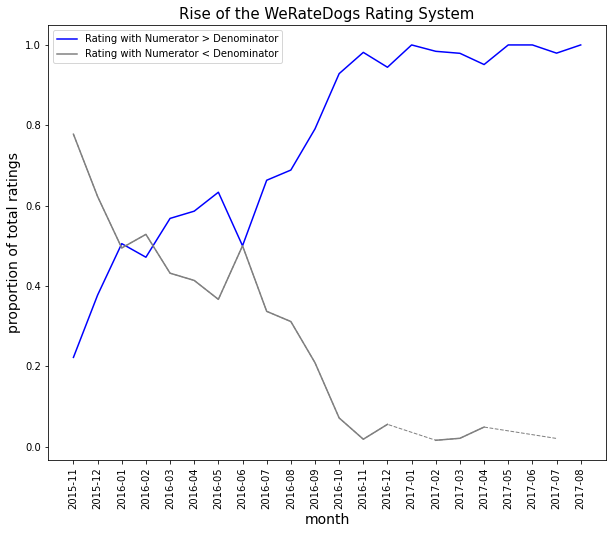

In [105]:
# get months of year for time series, x variable
x = df['monthyear'].unique()

# y variable is WRD ratings and "normal" ratings
y = WRD_rating_props
y1 = normal_rating_props

# mask for dotted lines
mask = np.isfinite(y1)

# create figure object
fig, ax = plt.subplots(figsize = (10,8))

#plot WRD ratings 
ax.plot(x, y,color = 'blue', label = 'Rating with Numerator > Denominator')

# plot dotted lines
line, = ax.plot(x[mask],y1[mask],color = 'grey', ls="--",lw=1)

#plot "normal" ratings
ax.plot(x,y1, color=line.get_color(), lw=1.5,label =  'Rating with Numerator < Denominator')
plt.xlabel('month',fontsize = 14)
plt.ylabel('proportion of total ratings',fontsize = 14)
plt.title('Rise of the WeRateDogs Rating System', fontsize = 15)
plt.xticks(rotation = 90);
plt.legend()
plt.show()

In the beginning, the WeRateDogs style ratings only represented about 20% of the total ratings, but by November 2016, almost *all* of the ratings have the denominator greater than the numerator, and the trend doesn't appear to be slowing.

From the data, it seems the page's typical rating system started off as a few over-the-top ratings for exceptional dogs here and there, but as the page and the rating system gained traction, having ratings of above 100% became standard practice to the point of almost making "normal" ratings disappear from the page. 

## Dog Stages
Next I'd like to look into the dog stages over time. I'll start by seeing how many of each stage are in the dataset.

In [106]:
df.stage.value_counts()

pupper            219
doggo              69
puppo              23
pupper, doggo      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: stage, dtype: int64

Other than the pupper stage, the others represent a very small part of the data. I can ask myself when each of the dog types appeared for the first time, excluding of course the doubled types ("doggo, floofer" for example).

In [107]:

stages = ['pupper','doggo','floofer','puppo']

# loop through the stages, get index( note that df is now sorted by monthyear column)
for stage in stages:
    index = df[df.stage == stage].first_valid_index()
    #print monthyear corresponding to index
    print(stage, "first appeared in " , df[df.stage == stage].monthyear[index])

pupper first appeared in  2015-12
doggo first appeared in  2016-04
floofer first appeared in  2016-01
puppo first appeared in  2016-06


The above shows that not all the stages were used since the beginning. Pupper appeared a month after, and floofer just one month after that, but doggo and pupper appeared several months later. The stages, much like the rating system, took time to become part of the typical WeRateDogs style. 

### Investigating the Use and Popularity of Pupper
As stated above, most of the stages don't appear a lot in the dataset. Pupper does, however, so it would be interesting to take a look at its use and popularity over time. 

I'm going to look at the proportions of tweets that are puppers each month, as well as the median like count of puppers compared with other stages or NaN stage.

In [108]:
# get subset of df that is puppers
puppers = df.query("stage == 'pupper'")

# get months in pupper df
pupper_months = puppers.monthyear.unique()

# # get count of tweets grouped by month... use .isin() to avoid NaNs with pupper months
total_counts = df[df.monthyear.isin(pupper_months)].groupby('monthyear').sum()['count']

# get count of pupper tweets each month
pupper_counts = puppers.groupby('monthyear').sum()['count']

# proportion of tweets that are puppers each month
pupper_prop = pupper_counts / total_counts

monthyear
2015-12    66.0
2016-01    44.0
2016-02    23.0
2016-03    12.0
2016-04     9.0
2016-05     9.0
2016-06     8.0
2016-07     9.0
2016-08     2.0
2016-09     8.0
2016-10     1.0
2016-11     4.0
2016-12     4.0
2017-01     3.0
2017-02     4.0
2017-03     3.0
2017-04     2.0
2017-05     1.0
2017-06     4.0
2017-07     3.0
Name: count, dtype: float64

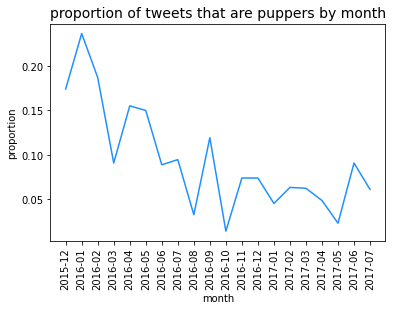

In [109]:
# graph change in proportion of puppers over time
plt.plot(pupper_months, pupper_prop, color = 'dodgerblue')
plt.xticks(rotation = 90)
plt.xlabel('month')
plt.ylabel('proportion')
plt.title('proportion of tweets that are puppers by month', fontsize = 14);

# add number of pupper each month for reference
pupper_counts

It seems that as the page evolved, pupper stage represented less and less tweets. From the pupper_counts series, we see that sometimes only one tweet in a given month is a pupper. 

Now I'll check out the popularity of puppers in terms of like count. I'm going to use the median to account for possible outliers, but it is important to reiterate that for some months, there are only one or two pupper tweets.

In [110]:
# get median like count for puppers grouped by month
pupperlikes = puppers.groupby('monthyear').median()['like_count']

# median like count for all other stages(including NaN) grouped by month
not_pupper_likes = df[(df.monthyear.isin(pupper_months))
                     & (df['stage'] != 'pupper')].groupby('monthyear').median()['like_count']

I'm going to use a barplot to show the difference in these two Series. Since puppers and not-puppers represent a categorical variable, I'll want to have all this info in the same DataFrame so that the 'hue' function will work. I'm going to convert the above two series to DataFrames, add a 'stage' column(pupper, not pupper) for each, and concatenate them.

I'm also going to place the above graph next to the bar plot I'll create as a reminder of how the use of pupper stage in the tweets has dwindled.

In [111]:
# convert above series to dataframe
pupperlikes = pd.DataFrame(pupperlikes)
not_pupper_likes = pd.DataFrame(not_pupper_likes)

# add stage column
pupperlikes['stage'] = 'pupper'
not_pupper_likes['stage'] = 'not pupper'

#concatenate
pupper_vs_not = pd.concat([pupperlikes, not_pupper_likes])

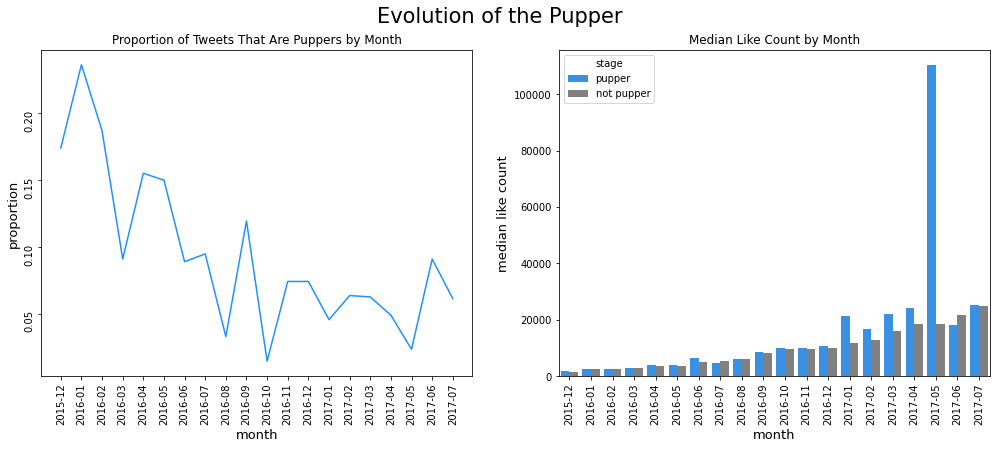

In [112]:
# make two axes for the two graphs
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (17,6))
fig.suptitle('Evolution of the Pupper', fontsize = 21)

# plot pupper proportions graph
ax1.plot(pupper_months, pupper_prop, color = 'dodgerblue')
ax1.tick_params(labelrotation=90)
ax1.set_title('Proportion of Tweets That Are Puppers by Month')
ax1.set_xlabel('month',fontsize = 13)
ax1.set_ylabel('proportion',fontsize = 13)

# dictionary for color palette
colors = {'pupper': 'dodgerblue', 'not pupper': 'grey'}

#plot median like_counts over time
ax2 = sns.barplot( data = pupper_vs_not, x = pupper_vs_not.index, y = 'like_count', hue = 'stage', palette = colors)
ax2.set_title('Median Like Count by Month')
ax2.set_xlabel('month', fontsize = 13)
ax2.set_ylabel('median like count', fontsize = 13)
plt.xticks(rotation = 90)
plt.savefig('pupper_graphs.jpeg',bbox_inches = 'tight')



From the above graph, it looks like toward the end of the dataset's time period, there is a rise in median like count for puppers relative to other stages. The WeRateDogs page used the term less and less, but to greater effect.

However, for June, 2017, pupper's median like count dropped back below the like count for other stages. It would be interesting to see more data to see if the trend continued upward, or if it was just a few month streak.

## Predicted Breeds Over Time
Since I have data on predicted dog breeds, I would like to know if a particular breed is consistently the most predicted breed of the month. First of all, I want to reiterate that these breeds are only *predictions*, so I'm only going to use those whose confidence level("p1_conf" in the dataframe) is greater than 0.8. Since this isn't a clinical trial, I don't feel it is necessary to be more strict. 

In [113]:
# get only rows with "p1_conf > 0.8 and that are dogs
high_conf_df = df[(df['p1_conf'] > .8) & (df['p1_dog'] == True)]

# see how many datapoints remain
high_conf_df.shape[0]

462

The high confidence level has whittled the data down significantly. A lot of tweets had a confidence level lower than .8, but that's okay. I want to have confident predictions to work with. 

Now that I have only breeds with a high confidence level, I'm going to get the most predicted breed for each month. For each month in the dataframe, I'm going to get the dog breed that appears most in tweets for that month, and store the breed and month in a dataframe, "breed_of_the_month".

In [114]:
# create empty dataframe with column for month and breed
breed_of_the_month = pd.DataFrame(columns = ['month','pred_breed'])

# loop through months of high_conf_df
for month in high_conf_df.monthyear.unique():
    breeds_for_month = high_conf_df[high_conf_df['monthyear'] == month]['p1'].value_counts() # value counts of each breed for month
    breed_dict = {'month': month, 'pred_breed': breeds_for_month.index[0]} # get dict of month and breed
    breed_of_the_month = pd.concat([breed_of_the_month, pd.DataFrame(breed_dict, index = [0])]) # concatenate with empty dataframe

In [115]:
breed_of_the_month

,month,pred_breed
0,2015-11,chihuahua
0,2015-12,pug
0,2016-01,pug
0,2016-02,golden_retriever
0,2016-03,chihuahua
0,2016-04,samoyed
0,2016-05,pembroke
0,2016-06,golden_retriever
0,2016-07,golden_retriever
0,2016-08,toy_poodle


It looks like the golden retriever appears a lot. I'll make a barplot to visualize these counts.

In [116]:
# create color dictionary for barplot palette to highlight golden retriever

color_dict = {}
for breed in breed_of_the_month.pred_breed.unique():
    if breed == 'golden_retriever':
            color_dict.update({breed: 'dodgerblue'})
    else:
        color_dict.update({breed: 'grey'})

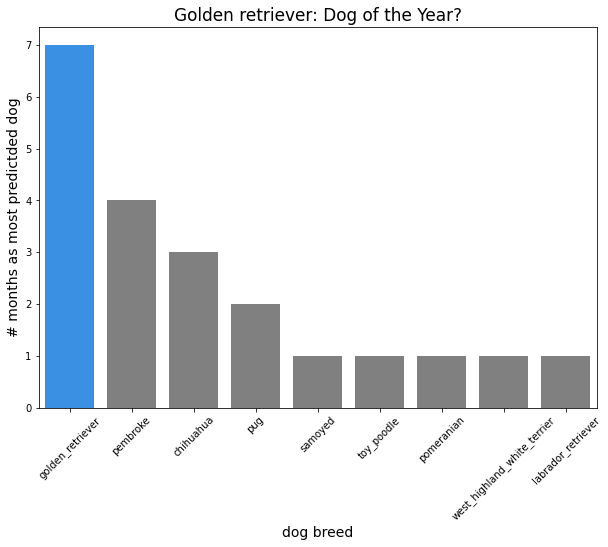

In [117]:
# get order of breeds of the month from greatest to least
order = breed_of_the_month['pred_breed'].value_counts().index


plt.figure(figsize = (10,7))
sns.countplot( x = breed_of_the_month['pred_breed'],order = order, palette = color_dict)
plt.xticks(rotation = 45,)
plt.xlabel('dog breed',fontsize = 14)
plt.ylabel('# months as most predictded dog',fontsize = 14)
plt.title('Golden retriever: Dog of the Year?', fontsize = 17);
plt.savefig('goldenretriever.jpg', bbox_inches = 'tight')

The golden retriever is the most predicted breed 7 months out of the 22 in the dataset. From the value counts above, it also appears these 7 months are somewhat spaced out. Given that these are only predictions, and most of the data was left out because of the confidence levels, I can't say whether or not the Golden Retriever is consistently the most tweeted breed across all months, but it is true for the parameters I set. 

# Conclusions

In the almost two years that the data spans, the voice of the WeRateDogs Twitter page evolved. The absurd ratings such as 13/10 or 16/10 became hallmarks. The page acquired a unique vocabulary for describing these dogs and their ratings, employing terms like "floofer","doggo", and "puppo". And the "pupper", a name that appeared on the page almost since the beginning, went from being used frequently to sparingly , but with greater success in terms of likes. 

However, one thing that stayed somewhat constant was the most tweeted breed per month, the golden retriever. But this is only true insofar as the neural network's predictions are true, and many tweets are left out due to low confidence level. 